# Pair Potentials Under External Fields

Experimental parameters have to be chosen carefully to maintain the Rydberg blockade as discussed in S. de Léséleuc, S. Weber, V. Lienhard, D. Barredo, H.P. Büchler, T. Lahaye, A. Browaeys, “Accurate mapping of multilevel Rydberg atoms on interacting spin-1/2 particles for the quantum simulation of Ising models”, [Phys. Rev. Lett. 120, 113602 (2018)](http://doi.org/10.1103/PhysRevLett.120.113602). Here we reproduce the result shown in Fig. 2c,d that the Rydberg blockade of $nD$-states can be broken by suprisingly small electric fields, i.e. by fields which cause only a tiny single-atom Stark shift. The parameter dependence of the electric field sensitivity can be studied by rerunning the Jupyter notebook for different interaction angles, external magnetic fields, or principal quantum numbers.

In [2]:
from collections.abc import Iterable

import matplotlib.pyplot as plt
import numpy as np

import pairinteraction.real as pi

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

We use pairinteraction's `KetAtom` class to define the single-atom state $\left|61d_{3/2},m_j=3/2\right\rangle$ of a Rubidium atom.

In [3]:
ket = pi.KetAtom("Rb", n=61, l=2, j=1.5, m=1.5)

Next, we define how to set up the single atom system.
We do this using a function, so we can easily create systems with the electric and magnetic field as parameters (only $z$-direction).

To limit the size of the basis, we have to choose cutoffs on states which couple to the above specified `ket`.
This is done by passing tuples of `(min, max)` values for the quantum numbers and energy to the basis constructor.



In [4]:
def get_system_atom(ez: float, bz: float) -> pi.SystemAtom:
    basis = pi.BasisAtom(
        ket.species,
        n=(ket.n - 2, ket.n + 2),
        l=(ket.l - 2, ket.l + 2),
        energy=(ket.get_energy(unit="GHz") - 30, ket.get_energy(unit="GHz") + 30),
        energy_unit="GHz",
    )
    print(f"Number of single-atom basis states: {basis.number_of_states}")

    system = pi.SystemAtom(basis)
    system.set_electric_field([0, 0, ez], unit="V/cm")
    system.set_magnetic_field([0, 0, bz], unit="gauss")
    system.diagonalize()

    return system

Akin to the single atom system, we now define how to create a pair atom system.
We want to parametrize this in terms of the single atom system and the spatial separation.

We compose a `SystemPair` from two identical `SystemAtom` because we are looking at two identical atoms.
Again, we have to restrict the energy range for the `BasisPair` to keep the basis size manageable.
Then we proceed to set the distance vector of the `SystemPair`.

To speed up the calculation, we specify additional arguments for the `pi.diagonalize` function.

In [5]:
def get_system_pair_list(
    system: pi.SystemAtom, distances: Iterable[float], angle_rad: float
) -> list[pi.SystemPair]:
    pair_energy = 2 * system.get_corresponding_energy(ket, unit="GHz")
    min_energy, max_energy = pair_energy - 1, pair_energy + 1

    pair_basis = pi.BasisPair(
        [system, system], energy=(min_energy, max_energy), energy_unit="GHz"
    )
    print(f"Number of two-atom basis states: {pair_basis.number_of_states}")

    pair_systems = [
        pi.SystemPair(pair_basis).set_distance_vector(
            [d * np.sin(angle_rad), 0, d * np.cos(angle_rad)], unit="micrometer"
        )
        for d in distances
    ]

    # Diagonalize the systems in parallel
    pi.diagonalize(
        pair_systems,
        diagonalizer="lapacke_evd",
        float_type="float32",
        energy_range=(pair_energy - 0.05, pair_energy + 0.05),
        energy_unit="GHz",
    )

    return pair_systems

Now, we use the definitions from above to compose and run our calculation for the specified parameters.

In [6]:
distances = np.linspace(14, 4, 100)  # µm
efields = [0, 0.020]  # V/cm
bfield = 6.9  # Gauss
angle = 78 * np.pi / 180  # rad

system_atom_dict: dict[float, pi.SystemAtom] = {}
system_pairs_dict: dict[float, list[pi.SystemPair]] = {}
for efield in efields:
    system_atom = get_system_atom(efield, bfield)
    system_atom_dict[efield] = system_atom
    system_pairs_dict[efield] = get_system_pair_list(system_atom, distances, angle)

Number of single-atom basis states: 90
Number of two-atom basis states: 682
Number of single-atom basis states: 90
Number of two-atom basis states: 692


Using `matplotlib`, we can now plot the resulting pair potential curves which are colored accordingly to the overlap with the investigated pair state.

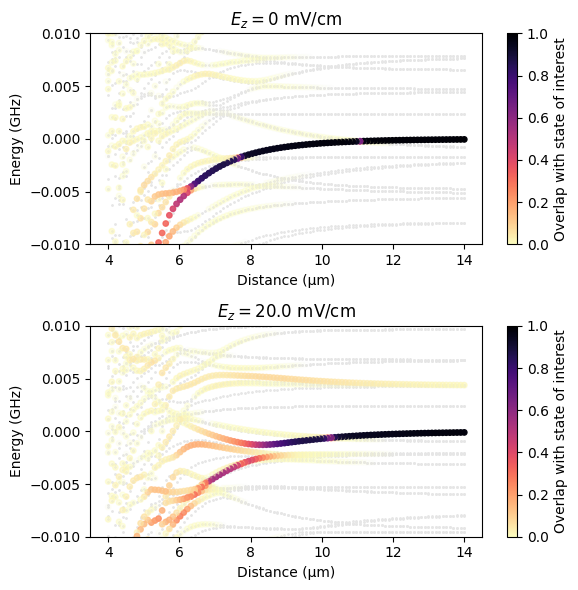

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6))

for i, efield in enumerate(efields):
    ax = axs[i]
    ax.set_title(f"$E_z = {efield * 1000}$ mV/cm")
    ax.set_xlabel("Distance (µm)")
    ax.set_ylabel("Energy (GHz)")
    ax.set_ylim(-0.01, 0.01)

    system_atom = system_atom_dict[efield]
    pair_energy = 2 * system_atom.get_corresponding_energy(ket, unit="GHz")
    system_pairs = system_pairs_dict[efield]

    energies = [system.get_eigenenergies(unit="GHz") - pair_energy for system in system_pairs]
    overlaps = [system.get_eigenbasis().get_overlaps([ket, ket]) for system in system_pairs]

    for x, es in zip(distances, energies):
        ax.plot([x] * len(es), es, c="0.9", ls="None", marker=".", ms=2, zorder=-10)

    min_overlap = 0.0001
    smap = plt.cm.ScalarMappable(cmap="magma_r")
    for x, es, os in zip(distances, energies, overlaps):
        inds = np.argwhere(os > min_overlap).flatten()
        inds = inds[np.argsort(os[inds])]
        if len(inds) > 0:
            alpha = 1 - np.maximum(np.log(os[inds]) / np.log(min_overlap), 0)
            ax.scatter(
                [x] * len(es[inds]),
                es[inds],
                c=os[inds],
                alpha=alpha,
                s=15,
                vmin=0,
                vmax=1,
                cmap=smap.cmap,
            )
    fig.colorbar(smap, ax=ax, label="Overlap with state of interest")

plt.tight_layout()
plt.show()